In [1]:
import cobra
import GEMS
import pandas as pd
import numpy as np
import os
import re


import pickle
from etcpy import etc
from etcpy import tempDep
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

In [2]:
data = GEMS.load_exp_data('../data/ExpGrowth.csv')
path = '../'
params = pd.read_csv(os.path.join(path,'data/BestParamsTopt129.csv'),index_col=0)
df = etc.calculate_thermal_params(params)
media = pd.read_csv('../data/media.csv', index_col=0)
dfae_batch = data[12].set_index('Ts').rename_axis(None)
lst = media['Name']
vals = media['Value']
media = dict(zip(lst,vals))
del media['EX_cro4_e']
del media['EX_fol_e']
del media['EX_ribflv_e']
media

{'EX_adn_e': 1000,
 'EX_ala__L_e': 1000,
 'EX_amp_e': 1000,
 'EX_arg__L_e': 1000,
 'EX_aso3_e': 1000,
 'EX_asp__L_e': 1000,
 'EX_ca2_e': 1000,
 'EX_cbl1_e': 1000,
 'EX_cd2_e': 1000,
 'EX_cl_e': 1000,
 'EX_cmp_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_cys__L_e': 1000,
 'EX_dad_2_e': 1000,
 'EX_dcyt_e': 1000,
 'EX_fe2_e': 1000,
 'EX_fe3_e': 1000,
 'EX_glc__D_e': 1000,
 'EX_glu__L_e': 1000,
 'EX_gly_e': 1000,
 'EX_gmp_e': 1000,
 'EX_gsn_e': 1000,
 'EX_h2o_e': 1000,
 'EX_h2s_e': 1000,
 'EX_h_e': 1000,
 'EX_hg2_e': 1000,
 'EX_his__L_e': 1000,
 'EX_hxan_e': 1000,
 'EX_ile__L_e': 1000,
 'EX_ins_e': 1000,
 'EX_k_e': 1000,
 'EX_leu__L_e': 1000,
 'EX_lipoate_e': 1000,
 'EX_lys__L_e': 1000,
 'EX_met__L_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_na1_e': 1000,
 'EX_nac_e': 1000,
 'EX_nh4_e': 1000,
 'EX_ni2_e': 1000,
 'EX_o2_e': 1000,
 'EX_phe__L_e': 1000,
 'EX_pheme_e': 1000,
 'EX_pi_e': 1000,
 'EX_pnto__R_e': 1000,
 'EX_pro__L_e': 1000,
 'EX_pydx_e': 10

In [3]:
def aerobic(params):
    # thermalParams: a dictionary with ids like uniprotid_Topt 
    df = etc.calculate_thermal_params(params)
    #mae = pickle.load(open(os.path.join(path,'models/aerobic.pkl'),'rb'))
    mae = cobra.io.load_matlab_model('../models/ecModel.mat')
    
    #mae.medium = media
    mae.reactions.EX_glc__D_e.lower_bound = -100
    mae.reactions.BIOMASS_Ec_iJO1366_core_53p95M.upper_bound = 50
    match = re.compile('usage_prot_*', re.IGNORECASE)
    for react in mae.reactions:
        if match.match(react.id) and react.lower_bound != -1000:
            ori_lb = react.lower_bound
            react.lower_bound = ori_lb*3.5

    
    try: 
        rae, gae, oae, cae, aae = etc.simulate_growth(mae,dfae_batch.index+273.15,df=df,sigma=0.5)
    except: 
        rae = np.zeros(dfae_batch.shape[0])
        model = None
    
    rae = [0 if x is None else x for x in rae]
    rae = [0 if x<1e-3 else x for x in rae]
    rexp = dfae_batch['r'].values
    print(rae)
    print(abs(rae - dfae_batch['r'].values))
    #print('r2_batch:',r2_score(rexp,rae))
    #print('MSE_ae',MSE(rexp,rae))
    return {'growth':np.array(rae), 'glucose':np.array(gae), 'oxygen': np.array(oae), 'carbonDioxide': np.array(cae), 'acetate': np.array(aae)}, r2_score(rexp,rae), MSE(rexp,rae)

In [4]:
rae, score, mse = aerobic(params)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-29
NGAM is: 3.23
Growth at  9.010000000000048 is:  0.013552183754382255
NGAM is: 3.23
Growth at  11.310000000000002 is:  0.02754180514422453
NGAM is: 3.23
Growth at  13.110000000000014 is:  0.046118814302525
NGAM is: 3.23
Growth at  14.710000000000036 is:  0.07088678347641757
NGAM is: 3.23
Growth at  15.910000000000025 is:  0.09618906667211931
NGAM is: 3.23
Growth at  17.310000000000002 is:  0.13484993709758708
NGAM is: 3.23
Growth at  18.610000000000014 is:  0.1813761207434277
NGAM is: 3.23
Growth at  20.010000000000048 is:  0.2450546218765298
NGAM is: 3.23
Growth at  21.310000000000002 is:  0.3186826851292453
NGAM is: 3.23
Growth at  22.710000000000036 is:  0.41548826605576794
NGAM is: 3.23
Growth at  24.010000000000048 is:  0.5230338390723042
NGAM is: 3.3016963946803655
Growth at  25.210000000000036 is:  0.6381575572993152
NGAM is: 3.6913019441404433
Growth at  26.410000000000025 is:  0.768720554

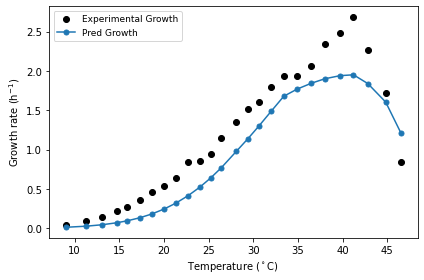

In [5]:
plt.figure()
plt.scatter(dfae_batch.index,dfae_batch['r'].values,label='Experimental Growth',color='k')
plt.plot(dfae_batch.index,rae['growth'],markersize=5,marker='o',label='Pred Growth')
#plt.plot(dfae_batch.index,rae['glucose'],markersize=5,marker='o',label='Glucose')
#plt.plot(dfae_batch.index,rae['oxygen'],markersize=5,marker='o',label='Oxygen')
plt.xlabel('Temperature ($^\circ$C)')
#plt.ylabel('Specific growth rate (h$^{-1}$)')
plt.ylabel('Growth rate (h$^{-1}$)')

plt.legend(fontsize=9,loc='upper left')
plt.tight_layout()
#plt.savefig('../results/plots/initialSimulation.svg')
plt.show()

In [6]:
df = pd.DataFrame(columns=['iter', 'temp', 'growth', 'o2flux', 'gluFlux', 'co2flux', 'acetateFlux', 'R2', 'MSE'])
df['iter'] = [12 for j in range(len(dfae_batch.index))]
df['temp'] = dfae_batch.index
df['growth'] = rae['growth']
df['o2flux'] = rae['oxygen']
df['gluFlux'] = rae['glucose']
df['co2flux'] = rae['carbonDioxide']
df['acetateFlux'] = rae['acetate']
df['R2'] = [score for j in range(len(dfae_batch.index))]
df['MSE'] = [mse for j in range(len(dfae_batch.index))]
df

,iter,temp,growth,o2flux,gluFlux,co2flux,acetateFlux,R2,MSE
0,12,9.01,0.013552,1.623968,2.356660,-0.387898,-0.259472,0.830729,0.110624
1,12,11.31,0.027542,2.283468,3.514478,-0.647722,-0.294136,0.830729,0.110624
2,12,13.11,0.046119,2.997575,4.554356,-1.080146,-0.304719,0.830729,0.110624
3,12,14.71,0.070887,3.749494,5.554756,-1.571203,-0.444874,0.830729,0.110624
4,12,15.91,0.096189,4.517908,6.613775,-1.996760,-0.508191,0.830729,0.110624
5,12,17.31,0.134850,5.729518,8.051623,-2.723090,-0.447549,0.830729,0.110624
6,12,18.61,0.181376,7.172988,9.577466,-3.647068,-0.284897,0.830729,0.110624
7,12,20.01,0.245055,9.027492,11.349504,-4.888977,-0.096476,0.830729,0.110624
8,12,21.31,0.318683,11.044550,13.166330,-6.268386,0.000000,0.830729,0.110624
9,12,22.71,0.415488,13.823303,16.362574,-8.085468,0.000000,0.830729,0.110624


In [7]:
df.to_csv('../results/onlyRelaxB.csv')